#### Imports

In [3]:
import glob
import math
import random
from typing import Callable, Union, Optional

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
from matplotlib import pyplot as plt
import networkx as nx
from scipy.spatial import distance as distance_calculator
import torch
from torch import Tensor
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.nn import GCNConv, global_max_pool
import torch.nn.functional as F
from torch_geometric.typing import PairTensor, OptTensor
from torch_geometric.utils import scatter, to_networkx
import seaborn as sn
from torch.nn import Sequential as Seq, Linear as Lin, Dropout, ReLU, BatchNorm1d as BN
from torch_geometric.nn.conv import MessagePassing
from torch_multi_head_attention import MultiHeadAttention
from torch_cluster import knn

#### Showing the difference between the same frame numbers on different days

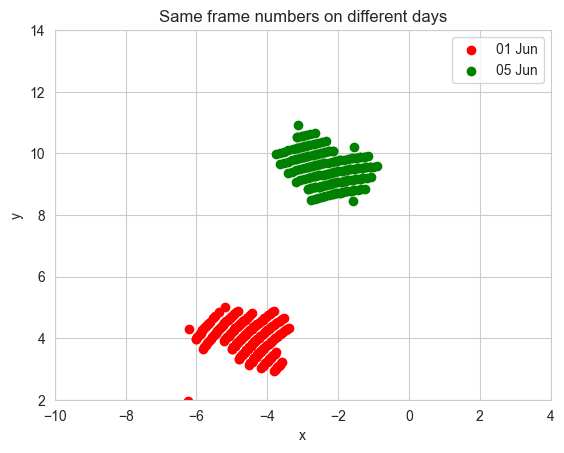

In [4]:
same_frame_1: DataFrame = pd.read_csv("data/2/2/Text_01Jun144751.csv104247.0.csv", header=None, dtype=float)
same_frame_2: DataFrame = pd.read_csv("data/3/3/Text_05Jun144421.csv104247.0.csv", header=None, dtype=float)

plt.scatter(same_frame_1.to_numpy()[:, 5], same_frame_1.to_numpy()[:, 4], c="red", label='01 Jun')
plt.scatter(same_frame_2.to_numpy()[:, 5], same_frame_2.to_numpy()[:, 4], c="green", label='05 Jun')
plt.legend()
plt.title("Same frame numbers on different days")
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(-10, 4)
plt.ylim(2, 14)
plt.show()

#### Loading the data
In each files, the frame numbers are shifted to come after the largest frame number in the previous file. This way all frame numbers are unique.


In [5]:
random.seed(42)
column_names=['range','azimuth','doppler','snr','y','x','current_frame','seq']

features0: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/0/0/*.csv")])
features0.insert(8, "Label", np.zeros(len(features0), dtype=int), True)
max_frame = max(features0["current_frame"])

features1: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/1/1/*.csv")])
features1.insert(8, "Label", np.ones(len(features1), dtype=int), True)
min_frame = min(features1["current_frame"])
shift = max_frame-min_frame+10
features1["current_frame"] += shift
max_frame = max(features1["current_frame"])

features2: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/2/2/*.csv")])
features2.insert(8, "Label", np.full(len(features2), 2, dtype=int), True)
min_frame = min(features2["current_frame"])
shift = max_frame-min_frame+10
features2["current_frame"] += shift
max_frame = max(features2["current_frame"])

features3: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/3/3/*.csv")])
features3.insert(8, "Label", np.full(len(features3), 3, dtype=int), True)
min_frame = min(features3["current_frame"])
shift = max_frame-min_frame+10
features3["current_frame"] += shift
max_frame = max(features3["current_frame"])

features4: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/4/4/*.csv")])
features4.insert(8, "Label", np.full(len(features4), 4, dtype=int), True)
min_frame = min(features4["current_frame"])
shift = max_frame-min_frame+10
features4["current_frame"] += shift
max_frame = max(features4["current_frame"])

features5: DataFrame = pd.concat(
    [pd.read_csv(filename, names=column_names, header=None, dtype=float) for filename in glob.glob("data/bigger/bigger/*.csv")])
features5.insert(8, "Label", np.full(len(features5), 5, dtype=int), True)
min_frame = min(features5["current_frame"])
shift = max_frame-min_frame+10
features5["current_frame"] += shift
max_frame = max(features5["current_frame"])

all_data = pd.concat([features0, features1, features2, features3, features4, features5])

all_data_grouped = all_data.groupby("current_frame")
print("Largest frame number: "+str(max_frame))
print("Total number of frames: "+str(len(all_data_grouped)))

Largest frame number: 87019891.0
Total number of frames: 22209


#### Showing the visual interpretation of consequent frames

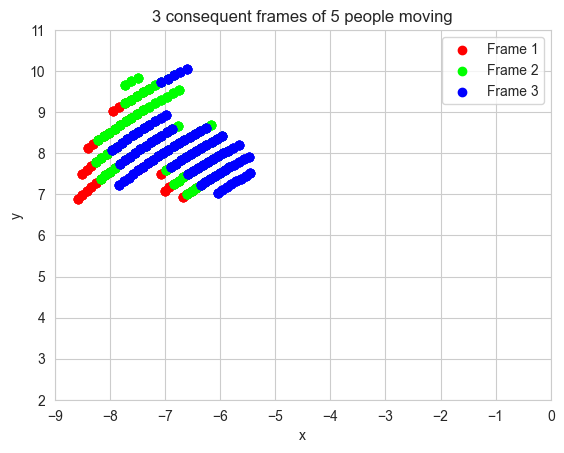

In [14]:
data = [frame.to_numpy() for (_, frame) in all_data_grouped]
frame_num = 21202
frame1 = data[frame_num]
frame2 = data[frame_num+1]
frame3 = data[frame_num+2]
plt.scatter(frame1[:, 5], frame1[:, 4], c="red", label="Frame 1")
plt.scatter(frame2[:, 5], frame2[:, 4], c="lime", label="Frame 2")
plt.scatter(frame3[:, 5], frame3[:, 4], c="blue", label="Frame 3")
plt.legend()
plt.title("3 consequent frames of 5 people moving")
plt.ylabel("y")
plt.xlabel("x")
plt.xlim(-9, 0)
plt.ylim(2, 11)
plt.show()

#### Generate graphs

In [6]:
def connect_frames(current_frame, previous_frame, k: int, start_index: int):
    """
    Calculates the edges between two frames. 
    
    :param current_frame: The current frame containing parameters to calculate the distance based on 
    :param previous_frame: The previous frame containing parameters to calculate the distance based on 
    :param k: The number of nearest neighbours to have in the graph
    :param start_index: The index to start labeling the nodes from
    :return: The values (distance between points) of the edges and an adjacency list containing the nodes that are connected in the graph
    """
    edges = []
    adjacency_list = []
    previous_nodes = np.arange(len(previous_frame))
    for i, point in enumerate(current_frame):
        distances = distance_calculator.cdist([point], previous_frame, 'euclidean')[0]
        idx = distances.argsort()[::-1]
        distances = 1/(distances[idx]+0.00000001)
        previous_nodes = previous_nodes[idx]
        neighbours = k
        if len(distances) < k:
            neighbours = len(distances)
        for j in range(neighbours):
            edges.append(distances[j])
            adjacency_list.append((i+start_index, previous_nodes[j]+start_index+len(current_frame)))
    return edges, adjacency_list

def create_graph_list(frames:[DataFrame], k = 1, frame_depth = 2):
    """
    Creates a list of Data objects that represents the graphs build from the input data. The edges in the graph connects the frames to the previous frame by connecting each points in a frame to it's nearest neighbour in the previous frame. The nodes contain information about: doppler, snr, y and x. The edges store information about the distance between the points (closer points have higher value).
    
    :param frames: input data grouped and sorted by the frame number
    :param k: the number of nearest neighbours to connect each points to
    :param frame_depth: the number of frames, one graph should contain
    :return: a list of Data objects, containing information about the created graphs
    """
    graphs = []
    for i, frame in enumerate(frames[frame_depth:]):
        nodes = []
        edges = []
        adjacency_list = []
        relevant_frames = frames[i: i + frame_depth + 1]
        point_data = [rf[['doppler','snr','y','x']] for rf in relevant_frames]
        time_distance = relevant_frames[-1].iloc[0, 6] - relevant_frames[0].iloc[0, 6]
        if time_distance > frame_depth * 3:
            continue
        point_data_array = [df.to_numpy() for df in point_data]
        start_index = 0
        for depth in range(frame_depth):
            pairwise_edges, pairwise_adjacency_list = \
                connect_frames(point_data_array[frame_depth-depth], point_data_array[frame_depth-depth-1], k, start_index)
            start_index += len(relevant_frames[frame_depth-depth])
            # pairwise_edges = pairwise_edges / np.linalg.norm(pairwise_edges)
            edges.extend(pairwise_edges)
            adjacency_list.extend(pairwise_adjacency_list)
            nodes.extend(point_data_array[frame_depth-depth])
        nodes.extend(point_data_array[0])
        label = frame["Label"].values[0]
        # edges = F.softmax(torch.tensor(np.array(edges), dtype=torch.float), dim=0)
        graphs.append(Data(x=torch.tensor(np.array(nodes), dtype=torch.float), 
                    edge_index=torch.tensor(np.array(adjacency_list), dtype=torch.int64).t().contiguous(),
                    edge_attr=torch.tensor(np.array(edges), dtype=torch.float),
                    y=torch.tensor(label, dtype=torch.int64)))
    return graphs


In [7]:

data_array = np.asarray([frame for (_, frame) in all_data_grouped], dtype="object")
sorted_data= sorted(data_array,key=lambda x:x["current_frame"].max(axis=0))
frame_graphs = create_graph_list(sorted_data, k=2)
print(len(frame_graphs))


16461


In [100]:
print(frame_graphs[0]["edge_attr"])
# g = to_networkx(frame_graphs[0], to_undirected=True)
# nx.draw(g)

tensor([0.2287, 0.2287, 0.2532, 0.2532, 0.1681, 0.1681, 0.1890, 0.1890, 0.2069,
        0.2069, 0.1315, 0.1315, 0.1492, 0.1492, 0.2505, 0.2505, 0.1537, 0.1537,
        0.1151, 0.1151, 0.1248, 0.1248, 0.1940, 0.1940, 0.1153, 0.1153, 0.1145,
        0.1145, 0.1515, 0.1515, 0.2201, 0.2201, 0.1302, 0.1302, 0.1147, 0.1147,
        0.1259, 0.1259, 0.2305, 0.2305, 0.1681, 0.1681, 0.1255, 0.1255, 0.1120,
        0.1120, 0.1654, 0.1654, 0.1364, 0.1364, 0.2412, 0.2412, 0.1514, 0.1514,
        0.1062, 0.1062, 0.1285, 0.1285, 0.1622, 0.1622, 0.1578, 0.1578, 0.1981,
        0.1981, 0.1953, 0.1953, 0.1092, 0.1092, 0.1078, 0.1078, 0.1933, 0.1933,
        0.1912, 0.1912, 0.2653, 0.2653, 0.1226, 0.1226, 0.1011, 0.1011, 0.2321,
        0.2321, 0.2285, 0.2285, 0.1213, 0.1213, 0.1944, 0.1944, 0.1473, 0.1473,
        0.1051, 0.1051, 0.2534, 0.2534, 0.2564, 0.2564, 0.1933, 0.1933, 0.1247,
        0.1247, 0.2380, 0.2380, 0.2408, 0.2408, 0.2707, 0.2707, 0.1627, 0.1627,
        0.1970, 0.1970, 0.2044, 0.2044, 

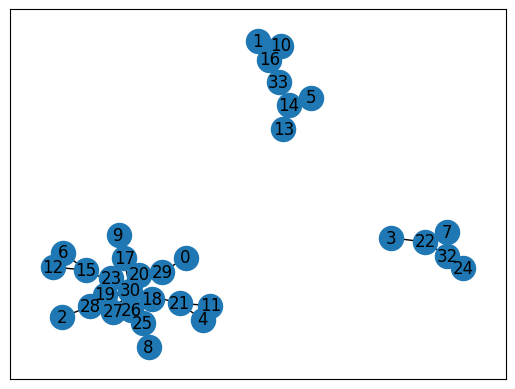

In [8]:
class GraphVisualization:

    def __init__(self):
        self.visual = []
        self.nodes = []

    def addEdge(self, a, b, d):
        temp = [a, b, {"dist": d}]
        self.visual.append(temp)

    def addNode(self, a):
        self.nodes.append(a)

    def visualize(self):
        gg = nx.Graph()
        gg.add_nodes_from(self.nodes)
        gg.add_edges_from(self.visual)
        nx.draw_networkx(gg)
        plt.show()

G = GraphVisualization()
# for i, _ in enumerate(frame_graphs[0].nodes):
#     G.addNode(i)
for i, adj in enumerate(frame_graphs[0].adjacency_list):
    G.addEdge(adj[0], adj[1], frame_graphs[0].edges[i])

G.visualize()

34


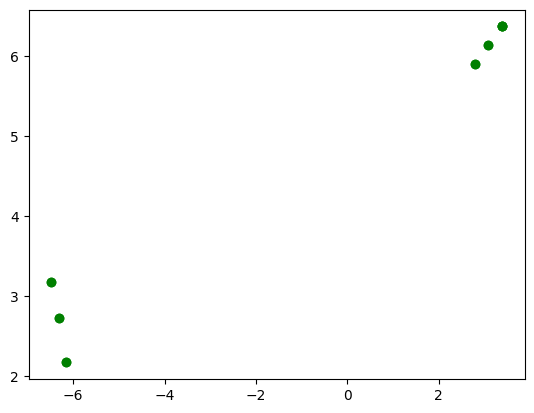

In [9]:

tiny_array = [t.to_numpy() for t in sorted_data]
print(len(tiny_array[0])+len(tiny_array[1])+len(tiny_array[2]))

# plt.scatter(tiny_array[0][:, 5], tiny_array[0][:, 4], c='blue')
# plt.scatter(tiny_array[1][:, 5], tiny_array[1][:, 4], c='red')
plt.scatter(tiny_array[2][:, 5], tiny_array[2][:, 4], c='green')
# plt.xlim(-10, 4)
# plt.ylim(2, 14)
plt.show()

In [10]:
class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, split='train', transform=None, pre_transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        if split == 'train':
            path = self.processed_paths[0]
        elif split == 'validation':
            path = self.processed_paths[1]
        else:
            path = self.processed_paths[2]
        self.load(path)

    @property
    def raw_file_names(self):
        return ['ply_data_train.h5', 'ply_data_validation.h5', 'ply_data_test.h5']

    @property
    def processed_file_names(self):
        return ['ply_data_train.pt', 'ply_data_validation.pt', 'ply_data_test.pt']

    def download(self):
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = [...]

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        self.save(data_list, self.processed_paths[0])
        # For PyG<2.4:
        # torch.save(self.collate(data_list), self.processed_paths[0])

#### Split the dataset

In [20]:
random.seed(42)
random.shuffle(frame_graphs)
train = frame_graphs[:int(0.7 * len(frame_graphs))]
test = frame_graphs[int(0.7 * len(frame_graphs)):int(0.85 * len(frame_graphs))]
val = frame_graphs[int(0.85 * len(frame_graphs)):]

train_dataloader = DataLoader(train[:1000], batch_size=32, shuffle=True) 
test_dataloader = DataLoader(train[:300], batch_size=32, shuffle=True) 

#### The Graph Neural Network Model

In [24]:
class GCN(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.conv1 = GCNConv(in_features, 256)
        self.conv2 = GCNConv(256, out_features)
        # self.conv3 = GCNConv(16, out_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        edge_weight = data.edge_attr
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv3(x, edge_index, edge_weight)
        x = scatter(x, data.batch, dim=0, reduce='mean')
        return F.log_softmax(x, dim=1)

#### Training the model with the data

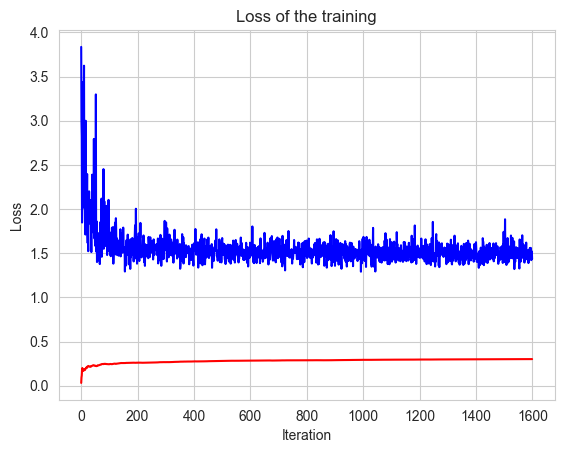

Accuracy: 0.30094
Loss: 1.4345354


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(4,6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
losses = []
correct = 0
count = 0
accuracies = []
for epoch in range(50):
    for train_batch in train_dataloader:
        train_batch = train_batch.to(device)
        optimizer.zero_grad()
        out = model(train_batch)
        pred = out.argmax(dim=1)
        correct += (pred == train_batch.y).sum()
        loss = F.nll_loss(out, train_batch.y)
        losses.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
        count += len(train_batch)
        acc = int(correct) / count
        accuracies.append(acc)

plt.plot(losses, c="blue")
plt.plot(accuracies, c="red")
plt.title("Loss of the training")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

print("Accuracy: "+str(accuracies[-1]))
print("Loss: "+str(losses[-1]))

#### Evaluate the trained model

In [26]:
model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for test_batch in test_dataloader:
    pred = model(test_batch).argmax(dim=1)
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(test_batch.y)
    # print("Predicted: " + str(pred) + ", real: "+ str(test_batch.y))
    correct += (pred == test_batch.y).sum()
acc = int(correct) / 300
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.3400


[[ 0  1  0  0  0  0]
 [ 0 22 24 23  1  6]
 [ 0 14 39 17  2  3]
 [ 0  5 16 25  0  4]
 [ 0 11 15 10  2 10]
 [ 0  5 29  2  0 14]]


Text(0.5, 47.7222222222222, 'Predicated Label')

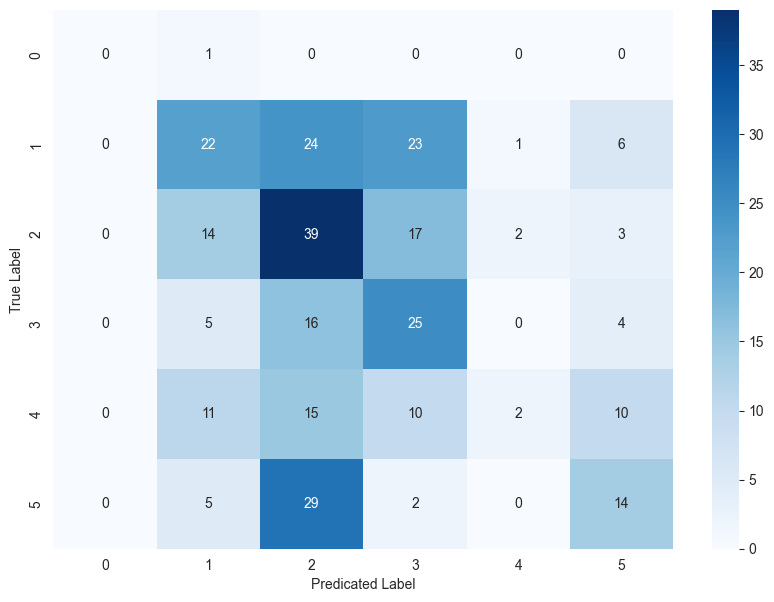

In [27]:
SHAPE_NAMES = [0,1,2,3,4,5]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
print(cm)
# cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

df_cm = pd.DataFrame(cm, index = SHAPE_NAMES,
              columns = SHAPE_NAMES)
plt.figure(figsize = (10,7))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.ylabel('True Label')
plt.xlabel('Predicated Label')

In [99]:
data_points = np.array([d.y.item() for d in train[:1000]])
zeros = np.where(data_points  == 0)[0]
print(len(zeros))
ones = np.where(data_points  == 1)[0]
print(len(ones))
print(len(np.where(data_points  == 2)[0]))
print(len(np.where(data_points  == 3)[0]))
print(len(np.where(data_points  == 4)[0]))
print(len(np.where(data_points  == 5)[0]))

2
231
253
209
155
150


#### Training with attention

In [9]:
def MLP(channels, batch_norm=True):
    return Seq(*[
        Seq(Lin(channels[i - 1], channels[i]), ReLU(), BN(channels[i]))
        for i in range(1, len(channels))
    ])

def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)

class GeneralizedTemporalSelfAttentionDynamicEdgeConv(MessagePassing):
    def __init__(self, nn: Callable, T: int, attention_in_features: int, head_num: int, k: int,
                 aggr: str = 'max',
                 num_workers: int = 1, spatio_temporal_factor: float = 0, **kwargs):
        super(GeneralizedTemporalSelfAttentionDynamicEdgeConv,
              self).__init__(aggr=aggr, flow='target_to_source', **kwargs)

        if knn is None:
            raise ImportError('`GeneralizedTemporalSelfAttentionDynamicEdgeConv` requires `torch-cluster`.')

        self.nn = nn
        self.multihead_attn = MultiHeadAttention(attention_in_features, head_num)
        self.k = k
        self.num_workers = num_workers
        self.spatio_temporal_factor = spatio_temporal_factor
        self.T = T
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.multihead_attn)
        reset(self.nn)

    def forward(
            self, x,
            edge_index,
            batch = None ) -> Tensor:
        # knn_input = torch.cat((x, sequence_number.reshape(-1, 1)), 1)
        # knn_input -= knn_input.min(0, keepdim=True)[0]
        # knn_input /= knn_input.max(0, keepdim=True)[0]
        # knn_input[:, -1] *= self.spatio_temporal_factor * math.sqrt(x.shape[-1])
        # source_data, source_batch, target_data, target_batch, index_mapper = make_proper_data(data=knn_input,
        #                                                                                       sequence_number=sequence_number,
        #                                                                                       batch=batch,
        #                                                                                       self_loop=False,
        #                                                                                       T=self.T)
        # if isinstance(x, Tensor):
        #     x: PairTensor = (x, x)
        # assert x[0].dim() == 2, \
        #     'Static graphs not supported in `GeneralizedTemporalSelfAttentionDynamicEdgeConv`.'
        # edge_index = knn(target_data, source_data, self.k, target_batch, source_batch,
        #                  num_workers=self.num_workers)
        # edge_index[1] = index_mapper[edge_index[1]]
        return self.propagate(edge_index, x=x, size=None, batch=batch)

    def message(self, x_i: Tensor, x_j: Tensor) -> Tensor:
        return self.nn(torch.cat([x_i, x_j - x_i], dim=-1))

    def aggregate(self, inputs: Tensor, index: Tensor,
                  batch: Tensor,
                  ptr: Optional[Tensor] = None,
                  dim_size: Optional[int] = None) -> Tensor:
        original_shape = inputs.shape
        # We assume K is fixed and the index tensor is sorted!
        attention_input_shape = list([int(original_shape[0] / self.k)]) + list(original_shape)
        attention_input_shape[1] = self.k
        self_attention_input = inputs.reshape(attention_input_shape)
        attn_output = self.multihead_attn(self_attention_input, self_attention_input, self_attention_input)
        attn_output = attn_output.reshape(original_shape)
        # Apply attention mechanism
        return scatter(attn_output, index, dim=self.node_dim, dim_size=dim_size,
                       reduce=self.aggr)

    def __repr__(self):
        return '{}(nn={}, k={})'.format(self.__class__.__name__, self.nn,
                                        self.k)



In [16]:
class Net(torch.nn.Module):
    def __init__(self, out_channels, graph_convolution_layers=2, T=1, k=4, spatio_temporal_factor=0.01, aggr='max'):
        super().__init__()
        # self.stn = STN3d()
        self.graph_convolution_layers = graph_convolution_layers

        self.conv1 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2 * 3, 64, 64, 64]),
                                                                     attention_in_features=64,
                                                                     head_num=8,
                                                                     k=k,
                                                                     spatio_temporal_factor=spatio_temporal_factor,
                                                                     T=T)
        self.conv2 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2 * 64, 128]),
                                                                     attention_in_features=128,
                                                                     head_num=8,
                                                                     k=k,
                                                                     spatio_temporal_factor=spatio_temporal_factor,
                                                                     aggr=aggr,
                                                                     T=T)
        self.conv3 = GeneralizedTemporalSelfAttentionDynamicEdgeConv(nn=MLP([2 * 128, 256]),
                                                                     attention_in_features=256,
                                                                     head_num=8,
                                                                     k=k,
                                                                     spatio_temporal_factor=spatio_temporal_factor,
                                                                     aggr=aggr,
                                                                     T=T)
        assert 1 <= graph_convolution_layers <= 3
        if graph_convolution_layers == 3:
            self.lin1 = MLP([256 + 128 + 64, 1024])
        elif graph_convolution_layers == 2:
            self.lin1 = MLP([128 + 64, 1024])
        elif graph_convolution_layers == 1:
            self.lin1 = MLP([64, 1024])

        self.mlp = Seq(
            MLP([4, 1024, 512]), Dropout(0.5), MLP([512, 256]), Dropout(0.5),
            Lin(256, out_channels))

    def forward(self, data):
        # sequence_numbers, pos, batch = data.x[:, 0].float(), data.pos.float(), data.batch
        # pos = pos.reshape(len(torch.unique(data.batch)), -1, 3).transpose(2, 1)
        # trans = self.stn(pos)
        # pos = pos.transpose(2, 1)
        # pos = torch.bmm(pos, trans)
        # pos = pos.reshape(-1, 3)
        # if self.graph_convolution_layers == 3:
        #     x1 = self.conv1(data.x, data.edge_index, data.batch)
        #     x2 = self.conv2(x1, data.edge_index, data.batch)
        #     x3 = self.conv3(x2, data.edge_index, data.batch)
        #     out = self.lin1(torch.cat([x1, x2, x3], dim=1))
        # elif self.graph_convolution_layers == 2:
        #     x1 = self.conv1(data.x, data.edge_index, data.batch)
        #     x2 = self.conv2(x1, data.edge_index, data.batch)
        #     out = self.lin1(torch.cat([x1, x2], dim=1))
        # else:
        #     x1 = self.conv1(data.x, data.edge_index, data.batch)
        #     out = self.lin1(x1)
        # out = global_max_pool(out, data.batch)
        out = self.mlp(data.x)
        out = scatter(out, data.batch, dim=0, reduce='mean')
        return F.log_softmax(out, dim=1)


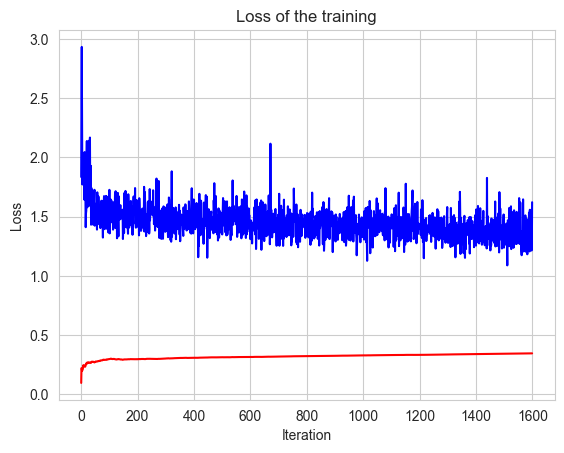

Accuracy: 0.3437
Loss: 1.6215618


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


model.train()
losses = []
correct = 0
count = 0
accuracies = []
for epoch in range(50):
    for train_batch in train_dataloader:
        train_batch = train_batch.to(device)
        optimizer.zero_grad()
        out = model(train_batch)
        pred = out.argmax(dim=1)
        correct += (pred == train_batch.y).sum()
        loss = F.nll_loss(out, train_batch.y)
        losses.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
        count += len(train_batch)
        acc = int(correct) / count
        accuracies.append(acc)
    scheduler.step()

plt.plot(losses, c="blue")
plt.plot(accuracies, c="red")
plt.title("Loss of the training")
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.show()

print("Accuracy: "+str(accuracies[-1]))
print("Loss: "+str(losses[-1]))

In [22]:
model.eval()
total_y_pred_label = []
total_y_true_label = []
correct = 0
for test_batch in test_dataloader:
    pred = model(test_batch).argmax(dim=1)
    total_y_pred_label.extend(pred)
    total_y_true_label.extend(test_batch.y)
    # print("Predicted: " + str(pred) + ", real: "+ str(test_batch.y))
    correct += (pred == test_batch.y).sum()
acc = int(correct) / 300
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.4300


[[ 0  0  0  0  0  0]
 [ 0 35 27  0  4  1]
 [ 0 19 55  5  2  2]
 [ 0 13 31 12  1  0]
 [ 0  6 26  4  3  5]
 [ 0  4 12  5  4 24]]


Text(0.5, 47.7222222222222, 'Predicated Label')

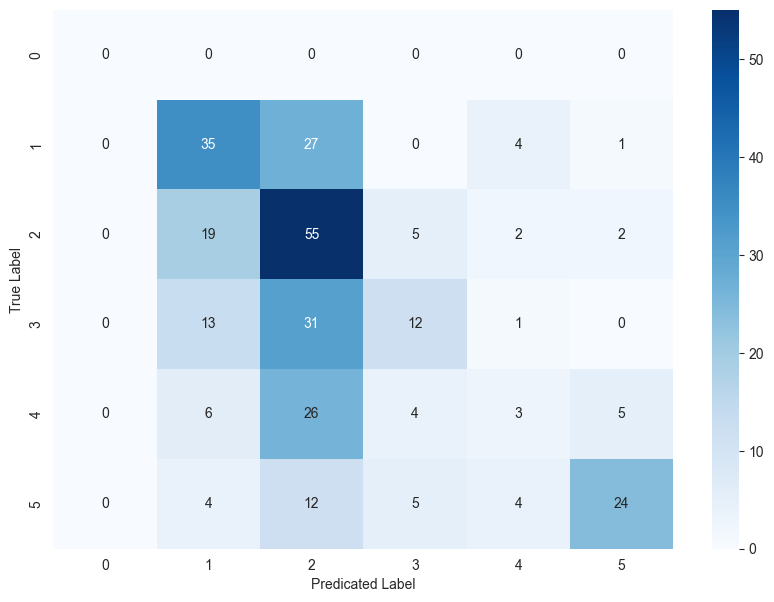

In [23]:
SHAPE_NAMES = [0,1,2,3,4,5]
total_y_pred = [pred_label.item() for pred_label in total_y_pred_label]
total_y_true = [true_label.item() for true_label in total_y_true_label]
cm = confusion_matrix(total_y_true, total_y_pred, labels=SHAPE_NAMES)
print(cm)
# cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]) * 100

df_cm = pd.DataFrame(cm, index = SHAPE_NAMES,
              columns = SHAPE_NAMES)
plt.figure(figsize = (10,7))
plot = sn.heatmap(df_cm, annot=True, cmap='Blues')
figure = plot.get_figure()
plt.ylabel('True Label')
plt.xlabel('Predicated Label')